# Relativistic Corrections to Power Spectrum Multipoles

Initiate notebook.

In [1]:
import corner
import h5py as hp
import matplotlib.pyplot as plt
import numpy as np

from conf import PATH
from horizonground.clustering_modification import (
    non_gaussianity_factor,
    relativistic_factor,
    standard_kaiser_factor,
)

%matplotlib notebook

LEGEND_SETTINGS = dict(
    handlelength=1.2, 
    handletextpad=0.5,
    fontsize=16,
)

Define fiducial parameters and parameter ranges.

In [2]:
FIDUCIAL_REDSHIFT = 2.
FIDUCIAL_LINEAR_BIAS = 2.
FIDUCIAL_NON_GAUSSNIANTY = 1.
TRACER_SAMPLE_PARAM = 1.6

In [3]:
ORDERS = [0, 2]
QUANTILES = [0.1587, 0.5, 0.8413]
wavenumbers = np.logspace(-3.5, -1.5, num=200+1)

Import sampled relativistic correction values.

In [4]:
REL_CORRECTION_CHAIN_FILE = PATH/"output"/(
    "decabinet/relcrct_relbias_z2._QSO_LF_PLE_emcee_1512630_32_5E5_by1.h5"
)

with hp.File(REL_CORRECTION_CHAIN_FILE, 'r') as relcrct_data:
    correction_samples = relcrct_data['distill/chain'][()]
    
correction_estimates = corner.quantile(correction_samples, QUANTILES)

## Relativistic modification

Compute Kaiser RSD and local non-Gaussianity results for comparison.

In [5]:
kaiser_result = {
    ell: standard_kaiser_factor(ell, FIDUCIAL_LINEAR_BIAS, FIDUCIAL_REDSHIFT)
        * np.ones_like(wavenumbers)
    for ell in ORDERS
}

In [6]:
non_gaussianity_result = {
    ell: non_gaussianity_factor(
        wavenumbers, ell,
        FIDUCIAL_NON_GAUSSNIANTY, FIDUCIAL_LINEAR_BIAS, FIDUCIAL_REDSHIFT,
        tracer_param=TRACER_SAMPLE_PARAM
    )
    for ell in ORDERS   
}

We now show the amount of modification relative to the standard Kaiser power spectrum multipoles.

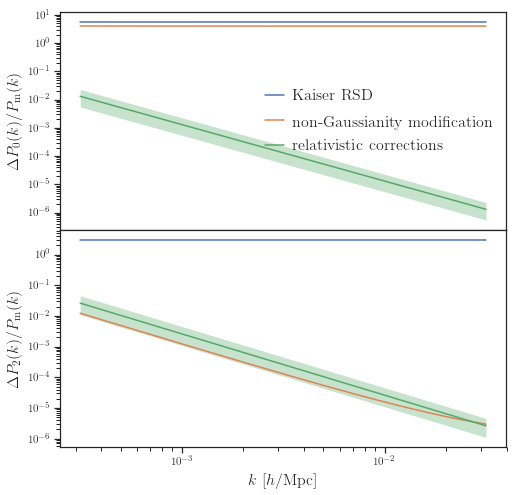

In [7]:
plt.close('all')
plt.figure("Power multipole modifications", figsize=(8, 8))

monopole = plt.subplot2grid((2, 1), (0, 0))

monopole.loglog(
    wavenumbers, kaiser_result[0] * np.ones_like(wavenumbers), 
    label="Kaiser RSD"
)
monopole.loglog(
    wavenumbers, non_gaussianity_result[0],
    label="non-Gaussianity modification"
)

rel_line = monopole.loglog(
    wavenumbers,
    relativistic_factor(
        wavenumbers, 0, FIDUCIAL_REDSHIFT, 
        correction_value=correction_estimates[1]
    ),
    label="relativistic corrections"
)

monopole.fill_between(
    wavenumbers,
    relativistic_factor(
        wavenumbers, 0, FIDUCIAL_REDSHIFT, 
        correction_value=correction_estimates[0]
    ),
    relativistic_factor(
        wavenumbers, 0, FIDUCIAL_REDSHIFT, 
        correction_value=correction_estimates[-1]
    ),
    color=rel_line[0].get_color(), linewidth=0., alpha=.33
)
    
monopole.legend(**LEGEND_SETTINGS)
monopole.get_xaxis().set_visible(False)
monopole.set_ylabel(r"$\Delta P_0(k) / P_\mathrm{m}(k)$", fontsize=16)

quadrupole = plt.subplot2grid((2, 1), (1, 0), sharex=monopole)

quadrupole.loglog(wavenumbers, kaiser_result[2] * np.ones_like(wavenumbers))
quadrupole.loglog(wavenumbers, non_gaussianity_result[2])

rel_line = quadrupole.loglog(
    wavenumbers,
    relativistic_factor(
        wavenumbers, 2, FIDUCIAL_REDSHIFT, 
        correction_value=correction_estimates[1]
    )
)

quadrupole.fill_between(
    wavenumbers,
    relativistic_factor(
        wavenumbers, 2, FIDUCIAL_REDSHIFT,
        correction_value=correction_estimates[0]
    ),
    relativistic_factor(
        wavenumbers, 2, FIDUCIAL_REDSHIFT,
        correction_value=correction_estimates[-1]
    ),
    color=rel_line[0].get_color(), linewidth=0., alpha=.33
)

quadrupole.set_xlabel(r"$k$ [$h$/Mpc]", fontsize=16)
quadrupole.set_ylabel(r"$\Delta P_2(k) / P_\mathrm{m}(k)$", fontsize=16)

plt.subplots_adjust(wspace=0, hspace=0)